# 1-1) 상권 클러스터링 (위치 고려, 밀집된 상권 찾아 data summation 진행) - 지헌


## 공유컵 사업 참여 추천 지역, 범위 설정
  ### 1) 매출+인구 고려 - 상권 데이터
        매출이 높고 인구가 많은 상권을 알아내자!
            - 유동인구 고려하는 이유: 테이크 아웃 인원 파악 위함
            - 20/30대 매출 건수, (생활인구 또는) 직장인구 데이터 사용
   - 1-1) 클러스터링 진행 - 거리가 가까운 상권의 경우를 클러스터링 해서, 값을 합쳐 새로운 행을 생성. (지헌) 
   - 1-2) 클러스터링 진행 - 매출과 인구를 고려한 클러스터링 (상은)
   - **추천 상권 도출
        
  ### 2) 위치+밀집도 고려 - 소상공인 카페 데이터
        카페 밀집도가 높은 지역 (가까운 거리 안에, 많은 카페가 존재하는) 을 알아내자!
        
   - 2-1) 클러스터링 진행 - 위치와 밀집도 고려해서 카페 밀집된 구역 추천 (수민)
   - **추천 지역 도출
        
        
#### ⇒  결론: 두 고려사항을 충족하는 지역 = 공유컵 시행 최적 지역 을 찾기 위함

In [17]:
import pandas as pd
import numpy as np

import seaborn as sns
import math
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import datetime
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as po

In [2]:
path = "../../데이터분석 공모전/2021 공공빅데이터 공모전/cup_sharing/"

# 1. 위치 기반 상권 클러스터링
거리가 가까운 상권의 경우를 클러스터링 해서, 값을 합쳐 새로운 행을 생성. (지헌) 


## 1)상권 매출, 생활인구, 직장인구 정보 합치기

In [18]:
comarea = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권영역).csv",encoding="cp949")
comarea_live = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권-생활인구).csv",encoding="cp949")
comarea_work = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권-직장인구).csv",encoding="cp949")
comarea_sales = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권-추정매출).csv",encoding="cp949")
around_comarea_live = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권배후지-상주인구).csv",encoding="cp949")
around_comarea_work = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권배후지-직장인구).csv",encoding="cp949")

In [19]:
comarea_sales['20_30_매출'] = comarea_sales['연령대_20_매출_건수']+comarea_sales['연령대_30_매출_건수']

In [20]:
cafe_sales = comarea_sales[['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '서비스_업종_코드_명', '분기당_매출_금액', '분기당_매출_건수','20_30_매출', '점포수']]
cafe_sales = cafe_sales[cafe_sales['서비스_업종_코드_명'] == '커피-음료']

In [21]:
def whenColAdd(df, year_col,quarter_col):
    year_quarter = []
    for year,quarter in zip(df[year_col],df[quarter_col]):
         year_quarter.append(str(year)+" "+str(quarter)+"분기")
    df['when'] = year_quarter
    return df

cafe_sales = whenColAdd(cafe_sales,'기준_년_코드','기준_분기_코드')
comarea_live = whenColAdd(comarea_live,'기준 년코드','기준_분기_코드')
comarea_work = whenColAdd(comarea_work,'기준_년월_코드','기준_분기_코드')
around_comarea_live = whenColAdd(around_comarea_live,'기준_년_코드','기준_분기_코드')
around_comarea_work = whenColAdd(around_comarea_work,'기준_년_코드','기준_분기_코드')

In [22]:
def pplNumColAdd(cafe_df, ppl_df, when_col, code_col, pplnum_col):
    ppl_num = []
    for when,code in zip(cafe_df[when_col], cafe_df[code_col]):
        temp = ppl_df[ppl_df[code_col] == code]
        temp = temp[temp[when_col] == when]
        if len(temp) == 0 : #만약 2021 2분기 자료가 없는 경우, 다른 분기의 자료를 대신 사용하고자 함.
            temp = ppl_df[ppl_df[code_col] == code]
        ppl_num.append(temp[pplnum_col][temp[pplnum_col].index.values[0]])
    return ppl_num        
        
cafe_sales['총_생활인구_수'] = pplNumColAdd(cafe_sales, comarea_live, 'when', '상권_코드', '총_생활인구_수')
cafe_sales['총_직장인구_수'] = pplNumColAdd(cafe_sales, comarea_work, 'when', '상권_코드', '총_직장_인구_수')

# 배후지 데이터의 경우 약 700개의 지역에 대한 데이터가 없기 때문에 사용하지 않기로 함.
# cafe_sales['총_배후지_생활인구_수'] = pplNumColAdd(cafe_sales, around_comarea_live, 'when', '상권_코드', '총_상주인구_수')
# cafe_sales['총_배후지_직장인구_수'] = pplNumColAdd(cafe_sales, around_comarea_work, 'when', '상권_코드', '총_직장_인구_수')

In [23]:
cafe_sales[['상권_코드_명','분기당_매출_금액','분기당_매출_건수','점포수','when','총_생활인구_수','총_직장인구_수','20_30_매출']]

,상권_코드_명,분기당_매출_금액,분기당_매출_건수,점포수,when,총_생활인구_수,총_직장인구_수,20_30_매출
27,강남 마이스 관광특구,2053055072,286867,51,2021 2분기,95914,15904,165542
68,잠실 관광특구,6210528801,613766,92,2021 2분기,2998695,24375,385198
124,종로?청계 관광특구,5318572821,723493,140,2021 2분기,3889871,32935,437248
167,동대문패션타운 관광특구,2255021123,377729,92,2021 2분기,3164130,6054,243332
221,명동 남대문 북창동 다동 무교동 관광특구,16167991368,2161255,353,2021 2분기,3714818,104830,1169503
...,...,...,...,...,...,...,...,...
64663,백석동길,209323065,11913,6,2021 1분기,172515,1797,5564
64676,명륜길,5239004,1373,5,2021 1분기,626489,56,1120
64702,돈화문로11가길,217121362,37589,18,2021 1분기,162400,3686,18319
64720,난계로27길,131686750,15362,5,2021 1분기,320864,201,8668


In [24]:
cafe_sales_202102 = cafe_sales[cafe_sales['when']=='2021 2분기']
cafe_sales_202102

## 2)상권 위치 정보 추가

In [25]:
from pyproj import Proj, transform

proj_1 = Proj(init='epsg:5181')
proj_2 = Proj(init='epsg:4326')

converted = transform(proj_1, proj_2, comarea['엑스좌표_값'].values, comarea['와이좌표_값'].values)
comarea['longitude'] = converted[0]
comarea['latitude'] = converted[1]

C:\Users\Jihun\anaconda3\envs\chaconda\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Jihun\anaconda3\envs\chaconda\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-25-6baae18fed6b>:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  converted = 

In [26]:
longitude = []
latitude = []

for code in cafe_sales_202102['상권_코드']:
    temp = comarea[comarea['상권_코드'] == code]
    longitude.append(temp['longitude'][temp['longitude'].index.values[0]])
    latitude.append(temp['latitude'][temp['latitude'].index.values[0]])
    
cafe_sales_202102['longitude'] = longitude
cafe_sales_202102['latitude'] = latitude

In [803]:
fig = px.scatter(cafe_sales_202102, 
                 x="longitude", 
                 y="latitude",
                width=700, height=500)
fig.show()

In [808]:
cafe_sales_202102[['상권_코드_명','서비스_업종_코드_명', '분기당_매출_건수', '20_30_매출', '점포수','총_직장인구_수', 'longitude', 'latitude']]

,상권_코드_명,서비스_업종_코드_명,분기당_매출_건수,20_30_매출,점포수,총_직장인구_수,longitude,latitude
27,강남 마이스 관광특구,커피-음료,286867,165542,51,15904,127.060059,37.511003
68,잠실 관광특구,커피-음료,613766,385198,92,24375,127.115275,37.516476
124,종로?청계 관광특구,커피-음료,723493,437248,140,32935,126.997374,37.569998
167,동대문패션타운 관광특구,커피-음료,377729,243332,92,6054,127.011025,37.567312
221,명동 남대문 북창동 다동 무교동 관광특구,커피-음료,2161255,1169503,353,104830,126.981856,37.564149
...,...,...,...,...,...,...,...,...
32306,백석동길,커피-음료,20760,9925,6,1797,126.967762,37.597113
32319,명륜길,커피-음료,1563,1134,5,56,126.994996,37.588720
32343,돈화문로11가길,커피-음료,44959,22794,19,3686,126.988419,37.575664
32360,난계로27길,커피-음료,18108,9739,5,201,127.022595,37.573212


In [863]:
cafe_sales_202102[cafe_sales_202102['dbscan']==47][['상권_코드_명', '분기당_매출_건수', '20_30_매출', '점포수','총_직장인구_수', 'longitude', 'latitude']].sort_values('상권_코드_명')

,상권_코드_명,분기당_매출_건수,20_30_매출,점포수,총_직장인구_수,longitude,latitude
27,강남 마이스 관광특구,286867,165542,51,15904,127.060059,37.511003
14085,삼성로57길,5131,1488,2,3231,127.058601,37.497200
14065,삼성로63길,4686,1399,6,1079,127.057811,37.499345
14041,삼성로64길,2337,741,4,2957,127.063195,37.500829
14019,삼성로69길,10181,4557,11,2064,127.057066,37.501346
13994,삼성로75길,4661,2454,9,1814,127.056038,37.503166
9308,삼성역_1,267830,159551,39,18695,127.060361,37.506678
9237,삼성역_2,174577,108444,16,7062,127.065136,37.508351
8829,삼성역_3,483160,322207,23,52277,127.063883,37.511704
10323,서울 강남구 대치역_1,242553,92974,8,102,127.061764,37.493288


In [864]:
cluster1_result[cluster1_result['상권_코드_명'] =="강남 마이스 관광특구"]

,상권_코드_명,분기당_매출_건수,20_30_매출,점포수,총_생활인구_수,총_직장인구_수,longitude,latitude
47,강남 마이스 관광특구,2338126.0,1301632.0,308.0,10270165.0,167999.0,127.060059,37.511003


## 3)상권 클러스터링 
* 너무 가까운 상권의 경우, 매출 건수와 인구를 합쳐서 고려하기위함

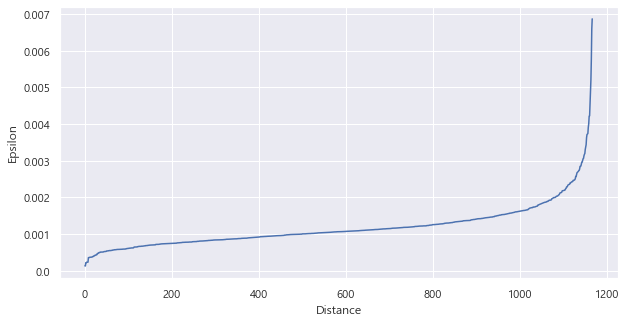

In [819]:
# we use nearestneighbors for calculating distance between points
from sklearn.neighbors import NearestNeighbors

X = comarea[['latitude','longitude']]

neigh=NearestNeighbors(n_neighbors=15)
distance=neigh.fit(X)
distances,indices=distance.kneighbors(X)
sorting_distances=np.sort(distances,axis=0)
# sorted_distances=sorting_distances[:,1]

fig, ax = plt.subplots(figsize=(10,5))
# plot between distance vs epsilon
plt.plot(sorted_distances)
plt.grid()
plt.xlabel("Distance")
plt.ylabel("Epsilon")
plt.grid(True)
plt.yticks([0.0,0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175],[0.0,0.001,0.002,0.003,0.004,0.005,0.006,0.007])
plt.show()

In [849]:
db = DBSCAN(eps=0.002, min_samples=4, metric='haversine')
model=db.fit(cafe_sales_202102[['longitude','latitude']])
cafe_sales_202102['dbscan'] = model.labels_

score_samples = silhouette_samples(cafe_sales_202102[['longitude','latitude']],cafe_sales_202102['dbscan'])
cafe_sales_202102['silhouette_coef'] = score_samples.copy()
sils = cafe_sales_202102.groupby('dbscan')['silhouette_coef'].mean()
print(sils[1:].mean())

0.403296692443261


In [851]:
fig = px.scatter(cafe_sales_202102, 
                 title="cafe_sales_202102", 
                 x="longitude", 
                 y="latitude",
                 color = 'dbscan',
                width=700, height=500)
fig.show()

In [852]:
import folium
from folium import plugins

g_map = folium.Map(location=[37.5083, 127.0583], zoom_start=10)

In [853]:
temp = cafe_sales_202102[cafe_sales_202102['dbscan']==43]

In [854]:
for long,lat in zip(temp['longitude'],temp['latitude']):
    marker = folium.Marker([lat,long],icon=folium.Icon(color='blue'))
    marker.add_to(g_map)

In [855]:
g_map

In [856]:
df = pd.DataFrame([])
df['상권_코드_명'] =[]
df['분기당_매출_건수'] =[]
df['20_30_매출'] = []
df['점포수'] =[]
df['총_생활인구_수'] =[]
df['총_직장인구_수'] =[]
df['longitude'] =[]
df['latitude'] =[]

for index in range(0,len(set(cafe_sales_202102['dbscan']))-1):
    temp1 = cafe_sales_202102[['분기당_매출_건수','점포수','총_생활인구_수','총_직장인구_수','20_30_매출','dbscan']]
    temp2 = cafe_sales_202102[['상권_코드_명','longitude','latitude','dbscan']]
    temp2 = temp2[temp2['dbscan']==index]
    temp = temp1[temp1['dbscan']==index]
    temp = temp[['분기당_매출_건수','점포수','총_생활인구_수','총_직장인구_수','20_30_매출']].sum()
    temp['상권_코드_명'] = temp2['상권_코드_명'][temp2['상권_코드_명'].index.values[0]]
    temp['longitude'] = temp2['longitude'][temp2['longitude'].index.values[0]]
    temp['latitude'] = temp2['latitude'][temp2['latitude'].index.values[0]]
    df=df.append([temp])

In [857]:
df.reset_index(inplace=True,drop=True)

In [858]:
sales_result = cafe_sales_202102[cafe_sales_202102['dbscan']==-1]
sales_result = sales_result[['상권_코드_명','분기당_매출_건수','20_30_매출','점포수','총_생활인구_수','총_직장인구_수','longitude','latitude']]
cluster1_result = pd.concat([df,sales_result]).reset_index(drop=True)

cluster1_result

,상권_코드_명,분기당_매출_건수,20_30_매출,점포수,총_생활인구_수,총_직장인구_수,longitude,latitude
0,동대문패션타운 관광특구,637312.0,405782.0,164.0,9466745.0,10966.0,127.011025,37.567312
1,명동 남대문 북창동 다동 무교동 관광특구,3686686.0,1984261.0,542.0,5059404.0,172521.0,126.981856,37.564149
2,길동복조리시장,598236.0,304815.0,215.0,28606766.0,11714.0,127.143675,37.538447
3,암사종합시장,739289.0,421437.0,242.0,19900216.0,21477.0,127.129134,37.550934
4,잠실 관광특구,753573.0,464046.0,121.0,6358907.0,29779.0,127.115275,37.516476
...,...,...,...,...,...,...,...,...
641,북촌로5나길,32721.0,19677.0,18.0,88947.0,234.0,126.983017,37.585791
642,북촌로5길,254755.0,162050.0,33.0,128077.0,503.0,126.981694,37.580349
643,북촌로11길,5178.0,2909.0,2.0,124660.0,671.0,126.984173,37.581313
644,백석동길,20760.0,9925.0,6.0,172958.0,1797.0,126.967762,37.597113
